        WAITCLASS         SAMPLE_TIME  DB_TIME
0  Administrative 2018-03-27 11:25:00    0.000
1     Application 2018-03-27 11:25:00    0.000
2             CPU 2018-03-27 11:25:00    0.000
3          Commit 2018-03-27 11:25:00    0.001
4     Concurrency 2018-03-27 11:25:00    0.000
WAITCLASS            Administrative  Application    CPU  Commit  Concurrency  \
SAMPLE_TIME                                                                    
2018-03-27 11:25:00             0.0          0.0  0.000   0.001          0.0   
2018-03-27 11:26:00             0.0          0.0  0.001   0.004          0.0   
2018-03-27 11:27:00             0.0          0.0  0.001   0.001          0.0   
2018-03-27 11:28:00             0.0          0.0  0.004   0.001          0.0   
2018-03-27 11:29:00             0.0          0.0  0.002   0.001          0.0   

WAITCLASS            Configuration  Network  Other  System I/O  User I/O  
SAMPLE_TIME                                                               
2018-03

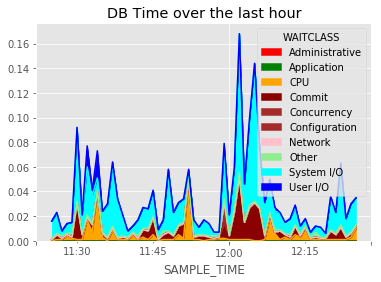

In [3]:

import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
 
def read_from_db (username, password, connectString, mode=None, save=False):
 
    if mode is None:
        connection = cx_Oracle.connect(username, password, connectString)
    else:
        connection = cx_Oracle.connect(username, password, connectString, mode)
    with connection:
        try:
            df = pd.read_sql_query("SELECT\
                                      wc.wait_class                    AS waitclass,\
                                      TRUNC(begin_time, 'MI')          AS sample_time,\
                                      round((wh.time_waited) / wh.intsize_csec, 3) AS DB_time\
                                    FROM V$SYSTEM_WAIT_CLASS wc,\
                                      v$waitclassmetric_history wh\
                                    WHERE wc.wait_class != 'Idle'\
                                          AND wc.wait_class_id = wh.wait_class_id\
                                    UNION\
                                    SELECT\
                                      'CPU'                   AS waitclass,\
                                      TRUNC(begin_time, 'MI') AS sample_time,\
                                      round(VALUE/100, 3)         AS DB_time\
                                    FROM v$sysmetric_history\
                                    WHERE GROUP_ID = 2\
                                          AND metric_name = 'CPU Usage Per Sec'\
                                    ORDER by sample_time, waitclass",
                                   connection)
            if save:
                df.to_csv('results.csv')
            return df
        except cx_Oracle.DatabaseError as dberror:
            print(dberror)
 
def read_from_file(filename):
    return pd.read_csv(filename, parse_dates=['SAMPLE_TIME'])
 
 
if __name__ == '__main__':
    style.use('ggplot')
    df = read_from_db(username='sys', password='ill6strio6s2011', connectString='DB-HRSUP.oii.oceaneering.com/HRSUP', mode=cx_Oracle.SYSDBA, save=True)
    # df = read_from_file('results.csv')
 
    print(df.head())
 
    pdf = df.pivot(index='SAMPLE_TIME', columns='WAITCLASS', values='DB_TIME')
 
    print(pdf.head())
 
    pdf.plot(kind='area', stacked=True, title='DB Time over the last hour', color=['red', 'green', 'orange', 'darkred', 'brown', 'brown', 'pink', 'lightgreen', 'cyan', 'blue'])
    plt.show()